Lucas Lima Neves - 201905463

Este notebook foi produzido como parte da disciplina Laboratório de Inovação e Automação, com o intuito de treinar um modelo classificador simples para cães e gatos.

Nele foi utilizada uma resnet18, com ciclo de treinametno de 10 épocas, em um dataset dividido na proporção 80/10/10

#Dados e configurações

##Importação das bibliotecas necessárias

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF


##Configurações

In [2]:
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
RANDOM_SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


##Diretórios


In [3]:
DATA_DIR = '/content/drive/MyDrive/2025-1/LabIA/Aula09/dataset/'
TRAIN_DIR = os.path.join(DATA_DIR, 'dataset_treino')
MODEL_SAVE_PATH = os.path.join(DATA_DIR, 'melhor_modelo.pth')

##Definição das transformações para data augmentation

In [4]:
def get_transforms():
    # Transformações para o conjunto de treino
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transforms, val_test_transforms


##Função para carregar os datasets e criar os dataloaders

In [5]:
def load_data():
    # Obtém as transformações
    train_transforms, val_test_transforms = get_transforms()

    # Carrega o dataset completo
    full_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=None)

    # Definir semente para reprodutibilidade
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

    # Obter índices por classe
    cat_indices = [i for i, (_, label) in enumerate(full_dataset.samples) if label == 0]  # gatos
    dog_indices = [i for i, (_, label) in enumerate(full_dataset.samples) if label == 1]  # cachorros

    # Embaralhar os índices
    random.shuffle(cat_indices)
    random.shuffle(dog_indices)

    # Separar índices para treino (400 por classe), validação (50 por classe) e teste (50 por classe)
    train_indices = cat_indices[:400] + dog_indices[:400]
    val_indices = cat_indices[400:450] + dog_indices[400:450]
    test_indices = cat_indices[450:500] + dog_indices[450:500]

    # Embaralhar os índices novamente
    random.shuffle(train_indices)
    random.shuffle(val_indices)
    random.shuffle(test_indices)

    # Criar subsets
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    test_dataset = Subset(full_dataset, test_indices)

    # Aplicar transformações
    train_dataset.dataset.transform = train_transforms
    val_dataset.dataset.transform = val_test_transforms
    test_dataset.dataset.transform = val_test_transforms

    # Criar dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Classes
    classes = ['gato', 'cachorro']

    return train_loader, val_loader, test_loader, classes



#Modelo

##Criação do modelo ResNet18 com transfer learning

In [6]:
def create_model(num_classes=2):
    # Carrega o modelo ResNet18 pré-treinado
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # Congela todos os parâmetros do modelo
    for param in model.parameters():
        param.requires_grad = False

    # Número de características na camada fully connected
    num_ftrs = model.fc.in_features

    # Substitui a última camada fully connected para classificação binária
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )

    # Move o modelo para a GPU se disponível
    model = model.to(DEVICE)

    return model

##Função para treinar o modelo

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    # Métricas para acompanhar
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Melhor acurácia de validação
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Época {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Modo de treino
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Cria barra de progresso para o treinamento
        train_progress = tqdm(train_loader, desc="Treinando", leave=False)

        # Treinando
        for inputs, labels in train_progress:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Zera os gradientes
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass e otimização
                loss.backward()
                optimizer.step()

            # Estatísticas
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Atualiza a barra de progresso com a perda atual
            train_progress.set_postfix(loss=loss.item())



        # Calcula e armazena as métricas de treino
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())

        print(f'Treino - Perda: {epoch_loss:.4f} Acurácia: {epoch_acc:.4f}')

        # Modo de avaliação
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        # Cria barra de progresso para a validação
        val_progress = tqdm(val_loader, desc="Validação", leave=False)

        # Avaliando
        for inputs, labels in val_progress:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass (sem calcular gradientes)
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # Estatísticas
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Atualiza a barra de progresso com a perda atual
            val_progress.set_postfix(loss=loss.item())

        # Calcula e armazena as métricas de validação
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc.item())

        print(f'Validação - Perda: {epoch_loss:.4f} Acurácia: {epoch_acc:.4f}')

        # Atualiza o scheduler com a métrica de validação
        scheduler.step(epoch_acc)

        # Salva o melhor modelo
        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f'Melhor modelo salvo com acurácia de validação: {best_val_acc:.4f}')

        print()

    # Carrega o melhor modelo
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))

    return model, train_losses, val_losses, train_accs, val_accs

##Função para avaliar o modelo no conjunto de teste

In [8]:
def evaluate_model(model, test_loader, criterion, classes):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # Para criar a matriz de confusão
    all_preds = []
    all_labels = []

    # Cria barra de progresso para o teste
    test_progress = tqdm(test_loader, desc="Avaliando", leave=False)

    for inputs, labels in test_progress:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass (sem calcular gradientes)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # Estatísticas
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Coleta as predições e labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Atualiza a barra de progresso com a perda atual
        test_progress.set_postfix(loss=loss.item())

    # Calcula a acurácia e perda no teste
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Teste - Perda: {test_loss:.4f} Acurácia: {test_acc:.4f}')

    # Calcula e mostra a matriz de confusão
    plot_confusion_matrix(all_labels, all_preds, classes)

    # Mostra o relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    return test_loss, test_acc, all_preds, all_labels


#Visualização dos resultados

In [9]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predição')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusão')
    plt.show()

# Função para plotar as métricas de treino
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    # Plot de perda
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Treino')
    plt.plot(val_losses, label='Validação')
    plt.title('Perda por Época')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    # Plot de acurácia
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Treino')
    plt.plot(val_accs, label='Validação')
    plt.title('Acurácia por Época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Função para visualizar algumas predições
def visualize_predictions(model, test_loader, classes, num_images=10):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//5 + 1, 5, images_so_far)
                ax.axis('off')

                # Desnormaliza a imagem para mostrar
                img = inputs.cpu()[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                # Define a cor do título baseado na predição (verde para correto, vermelho para incorreto)
                color = 'green' if preds[j] == labels[j] else 'red'

                ax.set_title(f'Pred: {classes[preds[j]]}\nReal: {classes[labels[j]]}', color=color)
                ax.imshow(img)

    plt.tight_layout()
    plt.show()

#Execução

Carregando os dados...
Dividindo em: 400 imagens para treino, 50 para validação e 50 para teste de cada classe...
Criando o modelo ResNet18...
Iniciando o treinamento...
Época 1/10
----------


Treino - Perda: 0.2869 Acurácia: 0.8725


Validação - Perda: 0.1117 Acurácia: 0.9600
Melhor modelo salvo com acurácia de validação: 0.9600

Época 2/10
----------


Treino - Perda: 0.2002 Acurácia: 0.9038


Validação - Perda: 0.0810 Acurácia: 0.9600

Época 3/10
----------


Treino - Perda: 0.2206 Acurácia: 0.9138


Validação - Perda: 0.0870 Acurácia: 0.9600

Época 4/10
----------


Treino - Perda: 0.1033 Acurácia: 0.9613


Validação - Perda: 0.1880 Acurácia: 0.9400

Época 5/10
----------


Treino - Perda: 0.0643 Acurácia: 0.9813


Validação - Perda: 0.1135 Acurácia: 0.9600

Época 6/10
----------


Treino - Perda: 0.0628 Acurácia: 0.9750


Validação - Perda: 0.0840 Acurácia: 0.9600

Época 7/10
----------


Treino - Perda: 0.0570 Acurácia: 0.9750


Validação - Perda: 0.0803 Acurácia: 0.9600

Época 8/10
----------


Treino - Perda: 0.0497 Acurácia: 0.9850


Validação - Perda: 0.0834 Acurácia: 0.9600

Época 9/10
----------


Treino - Perda: 0.0613 Acurácia: 0.9788


Validação - Perda: 0.0790 Acurácia: 0.9600

Época 10/10
----------


Treino - Perda: 0.0401 Acurácia: 0.9888


Validação - Perda: 0.0795 Acurácia: 0.9600



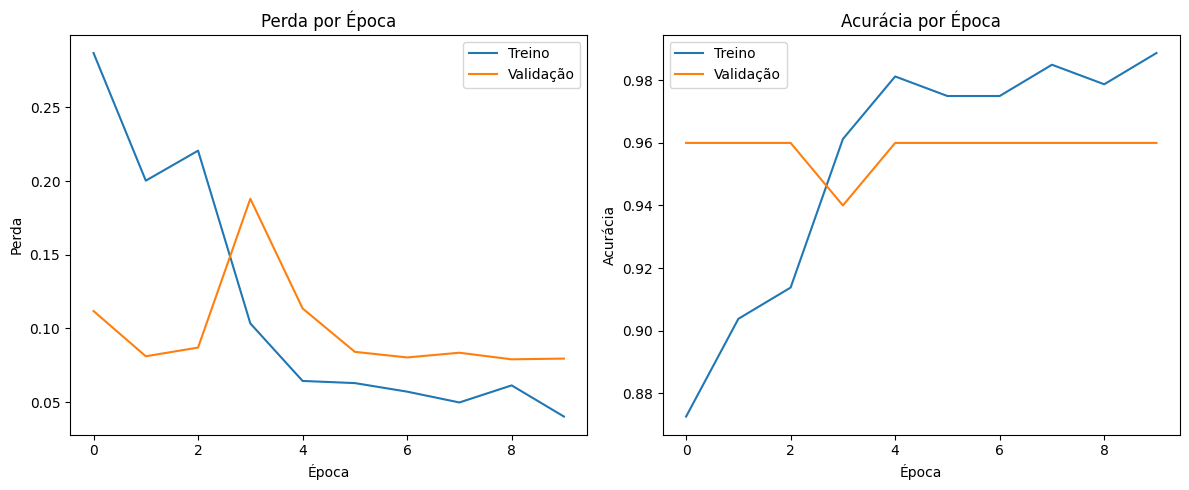

Avaliando o modelo no conjunto de teste...


Teste - Perda: 0.1289 Acurácia: 0.9600


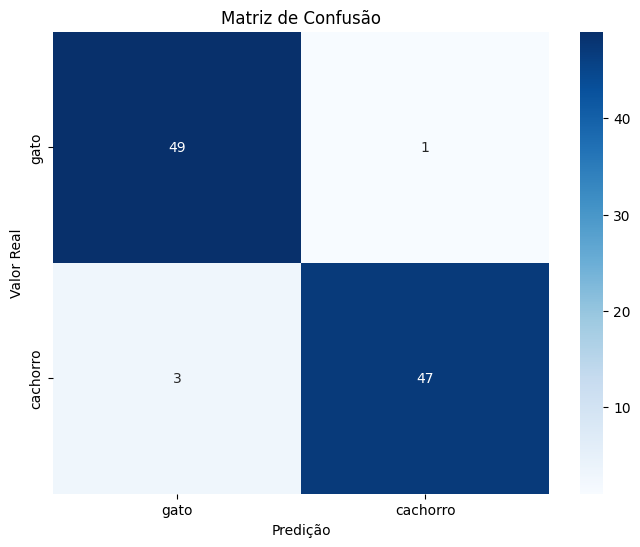


Relatório de Classificação:
              precision    recall  f1-score   support

        gato       0.94      0.98      0.96        50
    cachorro       0.98      0.94      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

Visualizando algumas predições...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


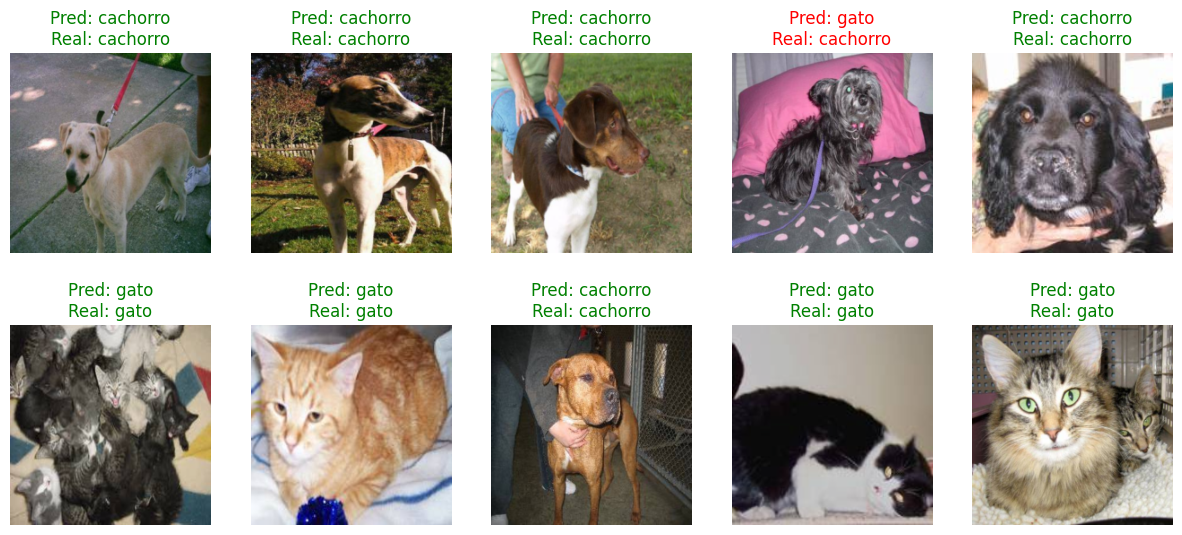

In [16]:
def main():
    # Carrega os dados
    print("Carregando os dados...")
    print("Dividindo em: 400 imagens para treino, 50 para validação e 50 para teste de cada classe...")
    train_loader, val_loader, test_loader, classes = load_data()

    # Cria o modelo
    print("Criando o modelo ResNet18...")
    model = create_model(num_classes=len(classes))

    # Define o critério de perda e otimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

    # Define o scheduler para reduzir a taxa de aprendizado quando a performance estagna
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

    # Treina o modelo
    print("Iniciando o treinamento...")
    model, train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS
    )

    # Plota as métricas de treino
    plot_metrics(train_losses, val_losses, train_accs, val_accs)

    # Avalia o modelo no conjunto de teste
    print("Avaliando o modelo no conjunto de teste...")
    test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion, classes)

    # Visualiza algumas predições
    print("Visualizando algumas predições...")
    visualize_predictions(model, test_loader, classes)

if __name__ == "__main__":
    main()